# Historical Activity of ClueBot NG

**Krishna Chaitanya Velag

In [2]:
import wmfdata as wmf
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

In [3]:
spark_session = wmf.spark.get_active_session()

if type(spark_session) != type(None):
    spark_session.stop()
else:
    print('no active session')

no active session


In [5]:
spark_session = wmf.spark.create_custom_session(
    master="yarn",
    app_name='cluebot-activity',
    spark_config={
        "spark.driver.memory": "4g",
        "spark.dynamicAllocation.maxExecutors": 64,
        "spark.executor.memory": "16g",
        "spark.executor.cores": 4,
        "spark.sql.shuffle.partitions": 256,
        "spark.driver.maxResultSize": "2g"
        
    }
)

SPARK_HOME: /usr/lib/spark3
Using Hadoop client lib jars at 3.2.0, provided by Spark.
PYSPARK_PYTHON=/opt/conda-analytics/bin/python3


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/19 05:48:29 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [6]:
spark_session

In [7]:
spark_session.sparkContext.setLogLevel("ERROR")

In [217]:
%%time

query = """
WITH
    base AS (
        SELECT 
            YEAR(event_timestamp) AS year,
            MONTH(event_timestamp) AS month,
            DAY(event_timestamp) AS day,
            DATE(event_timestamp) AS date,
            
            revision_id,
            CASE
                WHEN page_namespace_is_content AND revision_is_identity_revert THEN 'content_revert'
                WHEN page_namespace_is_content AND revision_is_identity_revert = False THEN 'content_edit'
                WHEN page_namespace_is_content = False AND revision_is_identity_revert THEN 'non_content_revert'
                WHEN page_namespace_is_content = False AND revision_is_identity_revert = False THEN 'non_content_edit'
            ELSE 'n/a'
            END AS edit_type            
        FROM
            wmf.mediawiki_history
        WHERE
            snapshot = '2023-07' AND
            wiki_db = 'enwiki' AND
            event_user_text = 'ClueBot NG' AND
            DATE(event_timestamp) <= DATE('2023-06-30') AND
            page_namespace_is_content IS NOT NULL AND
            revision_is_identity_revert IS NOT NULL
    )
            
        
SELECT
    year,
    month,
    day,
    edit_type,
    date,
    CAST(COUNT(DISTINCT revision_id) AS INT) AS edits
FROM 
    base
GROUP BY
    year,
    month,
    day,
    date,
    edit_type
ORDER BY
    year,
    month,
    day,
    date,
    edit_type
"""

result = wmf.spark.run(query)

CPU times: user 613 ms, sys: 94.1 ms, total: 707 ms
Wall time: 1min 16s


In [220]:
result['ymonth'] = pd.to_datetime(result['date']).dt.strftime('%Y-%m')

In [221]:
data = (
    result
    .pivot(
        index=['year', 'month', 'day', 'ymonth'], 
        columns='edit_type', values='edits')
    .fillna(0)
    .astype(int)
)

data.columns = [col for col in data.columns]
data.head(3)

content_edit  content_revert  non_content_edit  \
year month day ymonth                                                    
2010 10    28  2010-10             0               0                 1   
     11    2   2010-11             0             690               688   
           3   2010-11             0            1769              1440   

                        non_content_revert  
year month day ymonth                       
2010 10    28  2010-10                   0  
     11    2   2010-11                   0  
           3   2010-11                   9

In [222]:
data_monthly = (
    round(
        data
        .groupby(['year', 'month', 'ymonth'])
        .agg({
            'content_revert': ['sum', 'mean'], 
            'non_content_edit': ['sum', 'mean']
        })
    )
    .astype(int)
    .reset_index()
)

data_monthly.head(3)

year month   ymonth content_revert       non_content_edit      
                                  sum  mean              sum  mean
0  2010    10  2010-10              0     0                1     1
1  2010    11  2010-11          45176  1613            44905  1604
2  2010    12  2010-12          46536  1501            46604  1503

In [223]:
data_monthly.to_csv('cluebot_monthly_activity.tsv', sep='\t')

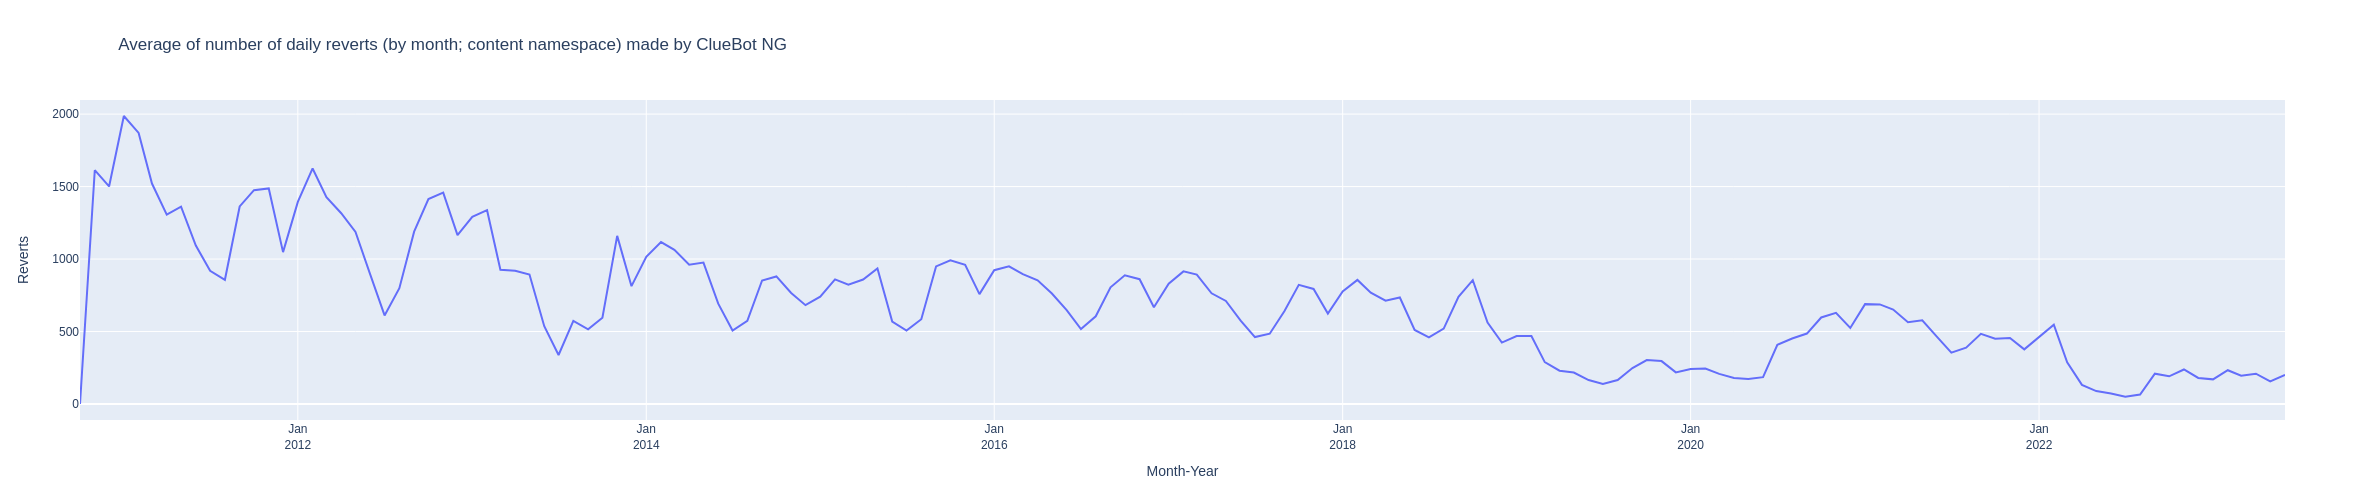

In [224]:
fig = (
    go
    .Figure([
        go.Scatter(
            x=data_monthly['ymonth'], 
            y=data_monthly.loc[:, ('content_revert', 'mean')])
    ])
    .update_layout(
        width=1250,
        height=500,
        title=dict(text='Average of number of daily reverts (by month; content namespace) made by ClueBot NG'),
        xaxis_tickformat= '%b<br>%Y'
    )
    .update_xaxes(title_text='Month-Year')
    .update_yaxes(title_text='Reverts')
)

fig.show()

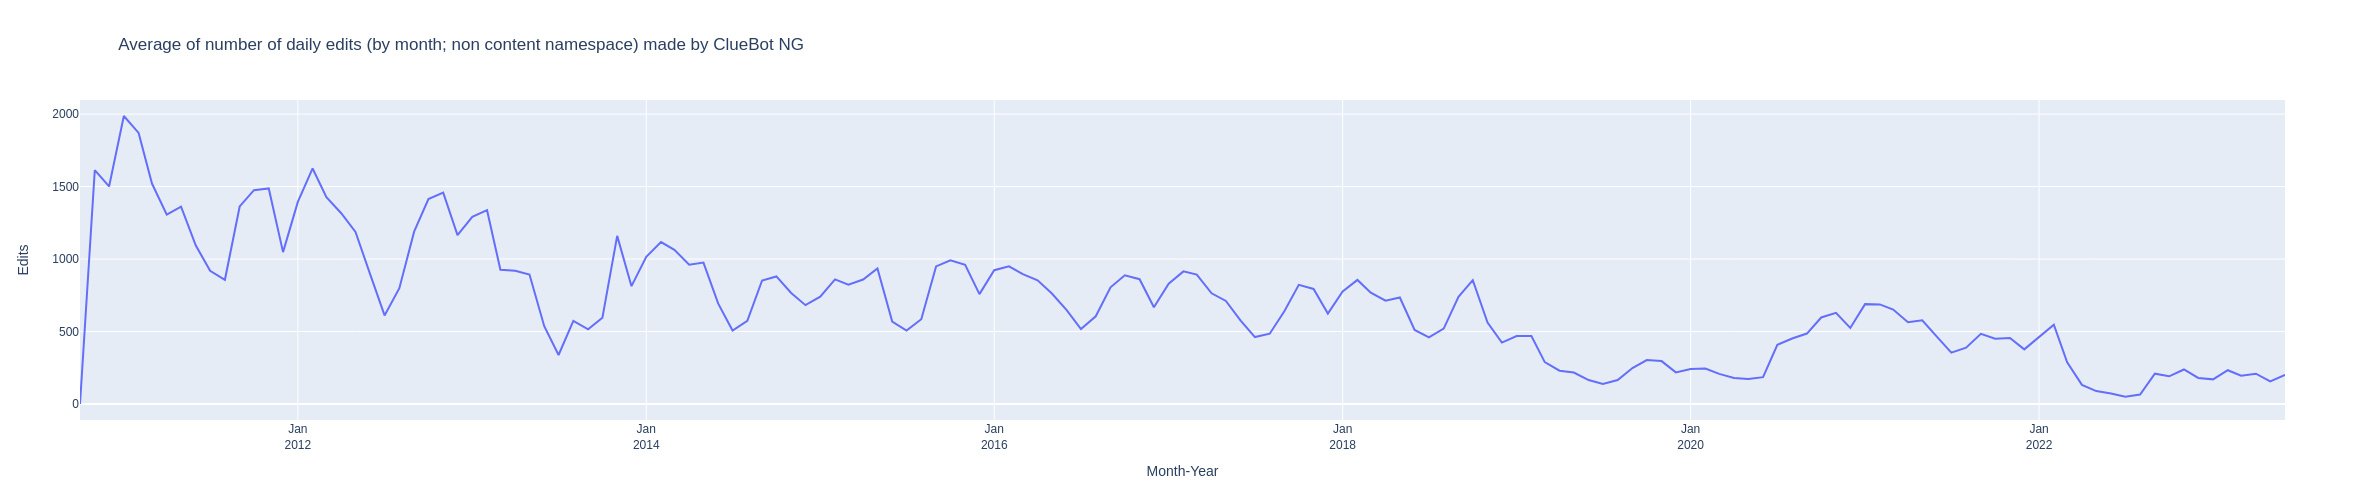

In [225]:
fig = (
    go
    .Figure([
        go.Scatter(
            x=data_monthly['ymonth'], 
            y=data_monthly.loc[:, ('content_revert', 'mean')])
    ])
    .update_layout(
        width=1250,
        height=500,
        title=dict(text='Average of number of daily edits (by month; non content namespace) made by ClueBot NG'),
        xaxis_tickformat= '%b<br>%Y'
    )
    .update_xaxes(title_text='Month-Year')
    .update_yaxes(title_text='Edits')
)

fig.show()